### 1 - Importações

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import copy
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
from rich import box
import copy
import time

### 2 - Definindo um agente iniciante

In [289]:
# Vamos definir um agente nível 1, com todos os atributos base

agent = {
    'name': 'Narcos',
    'level': 1,
    'hp': 30,
    'max_hp': 30,
    'base_stats': {
        'flat_damage_bonus': 10,
        'damage_reduction': 0.0
    },
    'exp': 0,
    'exp_to_level_up': 200
}

### 3 - Função que verifica a aptidão do agente para progredir de nível

In [290]:
def check_for_level_up(agent):
    """Verifica se o agente tem XP suficiente para subir de nível e aplica os bônus."""

    if agent['exp'] >= agent['exp_to_level_up']:

        agent['level'] += 1
        agent['exp'] = agent['exp'] - agent['exp_to_level_up'] # 'Zera' o exp antigo e atualiza pelo excedente
        
        # Aumenta a dificuldade para o próximo nível
        agent['exp_to_level_up'] = int(agent['exp_to_level_up'] * 1.2) 
                
        # Aumenta os atributos do agente permanentemente (apenas um esboço)
        agent['max_hp'] += 10
        agent['hp'] = agent['max_hp'] # Cura o agente ao subir de nível
        agent['base_stats']['flat_damage_bonus'] += 1
        agent['base_stats']['damage_reduction'] += 0.008

In [291]:
# Exemplo - agente recebe exp e sobe de nível
agent['exp'] += 300

check_for_level_up(agent)

print(f'O agente {agent['name']} agora é nível {agent['level']}!\n'
      f'HP: {agent['max_hp']}\n'
      f'Flat Damage Bonus: + {agent['base_stats']['flat_damage_bonus']}\n'
      f'Damage Reduction: {agent['base_stats']['damage_reduction']:.2f}%\n'
      f'XP para subir de nível: {agent['exp_to_level_up'] - agent['exp']}')

O agente Narcos agora é nível 2!
HP: 40
Flat Damage Bonus: + 11
Damage Reduction: 0.01%
XP para subir de nível: 140


### 4 - Simulando a progressão de dificuldade

In [292]:
# Carregamos todos os dados do ambiente para essa etapa

# Load skill and effects data
with open("../Ambient Data/skill_and_effects.yaml", "r", encoding="utf-8") as file:
    skill_and_effects_data = yaml.safe_load(file)

SKILL_CATALOG = skill_and_effects_data["skill_catalog"]
EFFECT_RULESET = skill_and_effects_data["effect_ruleset"]
BASE_SKILL_POINTS = skill_and_effects_data["base_skill_points"]
CD_MULTIPLIERS = skill_and_effects_data["cd_multipliers"]
EFFECT_COSTS = skill_and_effects_data["effect_costs"]

# Load equipment catalog data
with open("../Ambient Data/equipment_catalog.yaml", "r", encoding="utf-8") as file:
    equipment_catalog_data = yaml.safe_load(file)

EQUIPMENT_CATALOG = equipment_catalog_data["equipment_catalog"]

# Load enemies and events data
with open("../Ambient Data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

ENEMIES_CATALOG = enemies_and_events_data["pools"]["enemies"]
ROOM_EFFECT_CATALOG = enemies_and_events_data["pools"]["room_effects"]

Carregando a função de combate que foi criada no 'Combat system analysis.ipynb' (versão de 14-07-2025, 01:13 AM)

In [293]:
def initialize_combatant(name, hp, equipment, skills, team, room_effect_name: str = None):
    """Função auxiliar para preparar a 'ficha de personagem' de um combatente."""
    combatant = {
        'name': name, 'hp': hp, 'max_hp': hp, 'team': team,
        'skills': {name: SKILL_CATALOG[name] for name in skills},
        'equipment': {name: EQUIPMENT_CATALOG[name] for name in equipment},
        'cooldowns': {s: 0 for s in skills},
        'effects': {},        
        # Agrupa todos os stats que podem ser modificados temporariamente
        'base_stats': {
            'damage_modifier': 1.0, 'flat_damage_bonus': 0, 'damage_reduction': 0.0,
            'crit_chance': 0.0, 'accuracy': 1.0, 'evasion_chance': 0.0, 
            'dot_potency_modifier': 1.0
        },
        'on_hit_effects': [], 'on_being_hit_effects': [], 'special_effects': {}
    }
    # Aplica os bônus passivos dos itens
    for item_info in combatant['equipment'].values():
        for effect, value in item_info.get('passive_effects', {}).items():
            if effect == 'flat_hp_bonus':
                combatant['hp'] += value
                combatant['max_hp'] += value
            elif effect == 'damage_modifier':
                combatant['base_stats']['damage_modifier'] += value
            elif effect == 'flat_damage_bonus':
                combatant['base_stats']['flat_damage_bonus'] += value
            elif effect == 'damage_reduction':
                combatant['base_stats']['damage_reduction'] += value
            elif effect == 'crit_chance':
                combatant['base_stats']['crit_chance'] += value
            elif effect == 'accuracy':
                combatant['base_stats']['accuracy'] += value
            elif effect == 'evasion_chance':
                combatant['base_stats']['evasion_chance'] += value
            elif effect == 'dot_potency_modifier':
                combatant['base_stats']['dot_potency_modifier'] += value

        if 'on_hit_effect' in item_info:
            combatant['on_hit_effects'].append(item_info['on_hit_effect'])
        if 'on_being_hit_effect' in item_info:
            combatant['on_being_hit_effects'].append(item_info['on_being_hit_effect'])
        if 'special_effect' in item_info and item_info['special_effect'] == 'Revive':
            combatant['special_effects']['Revive'] = {'used': False, 'potency': EFFECT_RULESET['Revive']['potency']}

    # Aplica os efeitos permanentes da sala             
    if room_effect_name and room_effect_name in ROOM_EFFECT_CATALOG:
        room_rule = ROOM_EFFECT_CATALOG[room_effect_name]                                   
        if 'effect_to_apply' in room_rule:                
            effect_tag = room_rule['effect_to_apply']
            if effect_tag in EFFECT_RULESET:
                combatant['effects'][effect_tag] = {'duration': -1} # duração 'permanente'                                  
        
        # Aplica um modificador de status permanente para a luta
        if 'stat_modifier' in room_rule:
            for stat_key, value in room_rule['stat_modifier'].items():
                if stat_key in combatant['base_stats']:                    
                    combatant['base_stats'][stat_key] += value                         

    return combatant

def get_current_stats(combatant, effect_ruleset):
    """Calcula os atributos de um combatente, aplicando modificadores de efeitos ativos."""
    # Começa com uma cópia dos atributos base (para não modificar os originais)
    current_stats = combatant['base_stats'].copy()

    # Itera sobre os efeitos ativos do combatente
    for effect_name in combatant.get('effects', {}):
        rule = effect_ruleset.get(effect_name, {})
        if 'stat_modifier' in rule:
            for stat_key, value in rule['stat_modifier'].items():
                if stat_key in current_stats:
                    current_stats[stat_key] += value

    return current_stats

def simulate_combat(combatants_setup: dict, room_effect_name: str = None):
    """
    Simula um combate com N combatentes divididos em equipes.
    Retorna uma tupla: (número de turnos, ID da equipe vencedora).
    """
    # --- 1. SETUP INICIAL ---
    combatants = {
        name: initialize_combatant(
            name=name,
            hp=data['hp'],
            equipment=data['equipment'],
            skills=data['skills'],
            team=data['team'],
            room_effect_name=room_effect_name
    )
    for name, data in combatants_setup.items()
    }
    
    turn = 0
    max_turns = 100

    # --- 2. LOOP DE COMBATE ---
    while turn < max_turns:
        turn += 1
        
        # Cria a fila de turnos com todos os combatentes que ainda estão vivos
        turn_queue = [c for c in combatants.values() if c['hp'] > 0]
        
        for attacker in turn_queue:            

            # --- FASE DE INÍCIO DE TURNO ---

            if room_effect_name: # Verifica se há um efeito de sala ativo
                room_rule = ROOM_EFFECT_CATALOG.get(room_effect_name, {})
                                
                if 'persistent_effect' in room_rule:
                    persistent_rule = room_rule['persistent_effect']
                    
                    if persistent_rule.get('type') == 'Heal_Self':                        
                        heal_amount = attacker['max_hp'] * persistent_rule.get('heal_per_round', 0)
                        attacker['hp'] = min(attacker['hp'] + heal_amount, attacker['max_hp'])


            attacker_stats = get_current_stats(attacker, EFFECT_RULESET)

            active_effects = list(attacker['effects'].keys())
            is_stunned = False

            for effect_name in active_effects:
                if effect_name not in attacker['effects']: continue
                
                rule = EFFECT_RULESET.get(effect_name, {})
                if rule.get('type') == 'Heal_Self':
                    heal_amount = 0 

                    if 'potency' in rule:
                        heal_amount = attacker['max_hp'] * rule.get('potency', 0)
                                    
                    elif 'flat_amount' in rule:
                        heal_amount = rule.get('flat_amount', 0)
                    
                    if heal_amount > 0:
                        attacker['hp'] = min(attacker['hp'] + heal_amount, attacker['max_hp']) 
                             
                if rule.get('type') == 'DoT':
                    dot_damage = rule.get('damage_per_turn', 0) * attacker_stats.get('dot_potency_modifier', 1.0)
                    attacker['hp'] -= dot_damage
                if rule.get('type') == 'Control' and effect_name in ['Stun', 'Fear']:
                    is_stunned = True

                # Verifica se o efeito é permanente e diminui o CD, caso contrário
                duration = attacker['effects'][effect_name]['duration']
                if duration != -1:                    
                    attacker['effects'][effect_name]['duration'] -= 1

                    if attacker['effects'][effect_name]['duration'] <= 0:
                        del attacker['effects'][effect_name]
            
            # Verifica se o atacante morreu de DoT antes de agir
            if attacker['hp'] <= 0:
                # Lógica de Revive movida para o momento exato da "morte"
                if attacker['special_effects'].get('Revive', {}).get('used') == False:
                    revive_rule = attacker['special_effects']['Revive']
                    attacker['hp'] = attacker['max_hp'] * revive_rule['potency']
                    attacker['special_effects']['Revive']['used'] = True 
                else:
                    continue # Continua para o próximo atacante se já reviveu ou não tem revive

            if is_stunned: continue

            # --- FASE DE AÇÃO ---            
            available_actions = [s for s, cd in attacker['cooldowns'].items() if cd == 0] + ['Wait']
            action_name = np.random.choice(available_actions)

            if action_name != 'Wait':
                skill_info = attacker['skills'][action_name]
                
                potential_targets = [d for d in combatants.values() if d['hp'] > 0 and d['team'] != attacker['team']]
                if not potential_targets: continue

                is_aoe = 'AOE' in skill_info['tags']
                targets = potential_targets if is_aoe else [np.random.choice(potential_targets)]

                for defender in targets:
                    if defender['hp'] <= 0: continue

                    # Calcula modificações nos atributos dinâmicos                    
                    defender_stats = get_current_stats(defender, EFFECT_RULESET)
                    
                    # Calcula o dano final
                    base_damage = skill_info.get('damage', 0)                    
                    damage_mod = attacker_stats.get('damage_modifier', 1.0)
                    defense_mod = 1.0 - defender_stats.get('damage_reduction', 0.0)
                    is_crit = np.random.rand() < attacker_stats.get('crit_chance', 0.0)
                    crit_modifier = 2.0 if is_crit else 1.0

                    # Fórmula de dano a ser aplicada
                    final_damage = (base_damage + attacker_stats.get('flat_damage_bonus', 0)) * damage_mod * crit_modifier
                    final_damage_taken = final_damage * defense_mod

                    # --- APLICAÇÃO DE DANO E EFEITOS ---
                    if base_damage < 0:
                        attacker['hp'] -= base_damage
                    else:
                        hit_chance = attacker_stats.get('accuracy', 1.0) - defender.get('evasion_chance', 0.0)
                        hit_chance = max(0.05, min(hit_chance, 0.95))
                        if np.random.rand() < hit_chance:
                            defender['hp'] -= final_damage_taken
                            
                            # Aplica efeitos ON-HIT do atacante
                            for on_hit in attacker['on_hit_effects']:
                                if np.random.rand() < on_hit['chance']:
                                    tag = on_hit['effect_tag']
                                    if tag in EFFECT_RULESET:
                                        defender['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}
                            
                            # Aplica efeitos ON-BEING-HIT do defensor
                            if defender['hp'] > 0:
                                for on_being_hit in defender['on_being_hit_effects']:
                                    if np.random.rand() < on_being_hit['chance']:
                                        tag = on_being_hit['effect_tag']
                                        if tag == 'Reflect':
                                            attacker['hp'] -= final_damage_taken * EFFECT_RULESET['Reflect']['potency']
                                        elif tag in EFFECT_RULESET:
                                            attacker['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}

                            # Aplica efeitos da skill usada
                            for tag in skill_info['tags']:
                                if tag in EFFECT_RULESET:
                                    rule = EFFECT_RULESET[tag]
                                    target = attacker if rule.get('target') == 'Self' else defender
                                    target['effects'][tag] = {'duration': rule['duration']}
                    
                    attacker['cooldowns'][action_name] = skill_info['cd']

                    # Verifica se o defensor morreu e aplica Revive
                    if defender['hp'] <= 0:
                        if defender['special_effects'].get('Revive', {}).get('used') == False:
                            revive_rule = defender['special_effects']['Revive']
                            defender['hp'] = defender['max_hp'] * revive_rule['potency']
                            defender['special_effects']['Revive']['used'] = True

            # --- FIM DO TURNO DO ATACANTE ---
            for skill in attacker['cooldowns']:
                if attacker['cooldowns'][skill] > 0:
                    attacker['cooldowns'][skill] -= 1

        # --- FIM DA RODADA: Verificação de Fim de Combate ---
        teams_alive = {c['team'] for c in combatants.values() if c['hp'] > 0}
        
        if len(teams_alive) <= 1:
            winner_team = teams_alive.pop() if teams_alive else None            
            return (turn, winner_team)
            
    return (turn, None) # Empate

Quando um inimigo for gerado pela função geradora de conteúdo, ele será instanciado com base na profundidade que o agente alcançou até o momento (andar k)

In [294]:
def instantiate_enemy(enemy_name, current_floor_k):
    """
    Cria uma instância de um inimigo com stats escalonados pela profundidade do andar.
    """
    if enemy_name not in ENEMIES_CATALOG:
        return None

    # Copia os dados do inimigo do catálogo origem
    base_enemy_data = copy.deepcopy(ENEMIES_CATALOG[enemy_name])
    
    # Exemplo de escalonamento
    enemy_level_bonus = current_floor_k * 0.2 # Quantidade de EXP obtida escalona % com base no andar

    scaled_hp = int(base_enemy_data['hp'] * (1 + current_floor_k * 0.008)) # +8% HP por nível de bônus
    
    # Cria o dicionário final do inimigo para o combate
    instantiated_enemy = initialize_combatant(
        name=enemy_name,
        hp=scaled_hp,
        equipment=base_enemy_data['equipment'],
        skills=base_enemy_data['skills'],
        team=-1 # Time do inimigo
    )
    
    # Escalonando os outros atributos base
    instantiated_enemy['base_stats']['flat_damage_bonus'] += int(enemy_level_bonus * 0.12)
    instantiated_enemy['exp_yield'] = int(base_enemy_data['exp_yield'] * (1 + enemy_level_bonus * 0.15))

    return instantiated_enemy

In [295]:
def display_entity_info(entity, current_floor_k=None):
    """Função cosmética para exibir os dados de qualquer entidade (agente ou inimigo)."""
    console = Console()
    
    # Header
    name = entity.get('name', 'Unknown Entity')
    level = entity.get('level')
    header_title = f"{name}"
    if level: header_title += f" [Lvl {level}]"
    if current_floor_k: header_title += f" (Floor {current_floor_k})"

    hp = entity.get('hp', '?')
    max_hp = entity.get('max_hp', '?')
    hp_line = f"HP: {hp} / {max_hp}"

    exp_yield = entity.get('exp_yield')
    if exp_yield is not None:
        hp_line += f"   |   EXP Yield: {exp_yield}"
    elif 'exp' in entity:
        hp_line += f"   |   EXP: {entity['exp']} / {entity.get('exp_to_next_level', '?')}"

    console.print(Panel(Text(header_title, style="bold red"), subtitle=hp_line, expand=False, style="bold magenta"))

    # Equipment
    if 'equipment' in entity:
        equipment = entity['equipment']
        table = Table(title="Equipment", box=box.SQUARE, expand=False)
        table.add_column("Name", style="cyan bold")
        table.add_column("Type")
        table.add_column("Rarity")
        table.add_column("Passive Effects")

        # CASO 1: É um dicionário (inimigos instanciados)
        if isinstance(equipment, dict):
            for name, data in equipment.items():
                effects = "\n".join(f"{k.replace('_', ' ').title()}: {v}" for k, v in data.get('passive_effects', {}).items())
                table.add_row(name, data.get('type', '-'), data.get('rarity', '-'), effects or "-")
        
        # CASO 2: É uma lista (seu dummy_agent)
        elif isinstance(equipment, list):
            for item_name in equipment:
                item_data = EQUIPMENT_CATALOG.get(item_name, {})
                effects_str = "\n".join(f"{k.replace('_', ' ').title()}: {v}" for k, v in item_data.get('passive_effects', {}).items())
                table.add_row(item_name, item_data.get('type', '-'), item_data.get('rarity', '-'), effects_str or "-")

        console.print(table)

    # Skills
    if 'skills' in entity:
        skills = entity['skills']
        table = Table(title="Skills", box=box.SQUARE, expand=False)
        table.add_column("Skill", style="green bold")
        table.add_column("Damage", justify="center")
        table.add_column("CD", justify="center")
        table.add_column("Tags")

        # CASO 1: É um dicionário (inimigos instanciados)
        if isinstance(skills, dict):
            for skill, data in skills.items():
                tags = ', '.join(data.get('tags', []))
                table.add_row(skill, str(data.get('damage', 0)), str(data.get('cd', 0)), tags)
        
        # CASO 2: É uma lista (seu dummy_agent)
        elif isinstance(skills, list):
            for skill_name in skills:
                skill_data = SKILL_CATALOG.get(skill_name, {})
                tags_str = ', '.join(skill_data.get('tags', []))
                table.add_row(skill_name, str(skill_data.get('damage', 0)), str(skill_data.get('cd', 0)), tags_str)

        console.print(table)

    # Current Stats
    if 'base_stats' in entity:
        current_stats = get_current_stats(entity, EFFECT_RULESET)
        table = Table(title="Current Stats", box=box.SQUARE, expand=False)
        table.add_column("Stat", style="yellow")
        table.add_column("Value", justify="right")

        for stat, val in current_stats.items():
            if 'modifier' in stat or 'chance' in stat:
                val_str = f"{val:.2%}"
            else:
                val_str = str(val)
            table.add_row(stat.replace('_', ' ').title(), val_str)

        console.print(table)

Para validar esse esboço de modelo de progressão, escolhemos um inimigo que é desafiador em níveis baixos, mas ainda assim, oferece um desafio equilibrado

In [296]:
enemy_name = 'Cursed Knight'
current_floor_k = 16

enemy = instantiate_enemy(enemy_name, current_floor_k)
display_entity_info(enemy, current_floor_k)

╭──────────────────────────╮
│ Cursed Knight (Floor 16) │
╰─ HP: 176 / 176   |   EXP─╯

                           Equipment                           
┌─────────────────┬──────────┬────────┬───────────────────────┐
│ Name            │ Type     │ Rarity │ Passive Effects       │
├─────────────────┼──────────┼────────┼───────────────────────┤
│ Iron Sword      │ Weapon   │ Common │ Damage Modifier: 0.08 │
│ Chain Shirt     │ Armor    │ Common │ Flat Hp Bonus: 20     │
│ Amulet of Vigor │ Artifact │ Common │ Flat Hp Bonus: 10     │
└─────────────────┴──────────┴────────┴───────────────────────┘

                     Skills                      
┌──────────────┬────────┬────┬──────────────────┐
│ Skill        │ Damage │ CD │ Tags             │
├──────────────┼────────┼────┼──────────────────┤
│ Heavy Blow   │   25   │ 3  │ Damage, Physical │
│ Stone Shield │   0    │ 3  │ Buff_Defense     │
│ Wait         │   0    │ 0  │ Wait             │
└──────────────┴────────┴────┴──────────────────┘

          Current Stats           
┌──────────────────────┬─────────┐
│ Stat                 │   Value │
├──────────────────────┼─────────┤
│ Damage Modifier      │ 108.00% │
│ Flat Damage Bonus    │       0 │
│ Damage Reduction     │     0.0 │
│ Crit Chance          │   0.00% │
│ Accuracy             │     1.0 │
│ Evasion Chance       │   0.00% │
│ Dot Potency Modifier │ 100.00% │
└──────────────────────┴─────────┘

Vamos criar um agente dummy (com política aleatória), a fim de observar escalonamento de dificuldade na prática

In [297]:
dummy_agent = {
    'name': 'So Dumb',
    'level': 16,
    'hp': 130,
    'max_hp': 130,
    'equipment': ['Shortsword', 'Leather Tunic', 'Tome of Haste'],
    'skills': ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait'],
    'base_stats': {
        'flat_damage_bonus': 10,
        'damage_reduction': 0.0
    },
    'team': 1,
    'exp': 20,
    'exp_to_level_up': 200
}

display_entity_info(dummy_agent, current_floor_k)

╭─────────────────────────────╮
│ So Dumb [Lvl 16] (Floor 16) │
╰─ HP: 130 / 130   |   EXP: 2─╯

                          Equipment                          
┌───────────────┬──────────┬────────┬───────────────────────┐
│ Name          │ Type     │ Rarity │ Passive Effects       │
├───────────────┼──────────┼────────┼───────────────────────┤
│ Shortsword    │ Weapon   │ Common │ Flat Damage Bonus: 2  │
│ Leather Tunic │ Armor    │ Common │ Flat Hp Bonus: 15     │
│ Tome of Haste │ Artifact │ Rare   │ Damage Modifier: 0.05 │
└───────────────┴──────────┴────────┴───────────────────────┘

                     Skills                      
┌──────────────┬────────┬────┬──────────────────┐
│ Skill        │ Damage │ CD │ Tags             │
├──────────────┼────────┼────┼──────────────────┤
│ Quick Strike │   10   │ 1  │ Damage, Physical │
│ Heavy Blow   │   25   │ 3  │ Damage, Physical │
│ Stone Shield │   0    │ 3  │ Buff_Defense     │
│ Wait         │   0    │ 0  │ Wait             │
└──────────────┴────────┴────┴──────────────────┘

        Current Stats        
┌───────────────────┬───────┐
│ Stat              │ Value │
├───────────────────┼───────┤
│ Flat Damage Bonus │    10 │
│ Damage Reduction  │   0.0 │
└───────────────────┴───────┘

Nosso objetivo é determinar se o combate de fato está balanceado para profundidades maiores.
Para isso, faremos 5000 simulações de combate contra o mesmo oponente, coletaremos os resultados e debateremos.

Iniciando 5000 simulações do Agente Nv. 16 vs Cursed Knight Nv. 16...
Simulações concluídas em 3.24 segundos.
\n--- Resultados da Análise ---
Taxa de Vitória do Agente: 63.22%
Média de Turnos por Combate (TTK): 27.20 (±4.80)


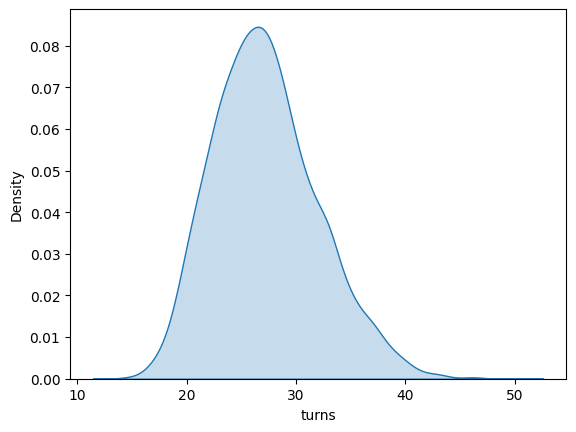

In [298]:
# Parâmetros de simulação
n_simulations = 5000
all_results = []

print(f"Iniciando {n_simulations} simulações do Agente Nv. {dummy_agent['level']} vs {enemy_name} Nv. {current_floor_k}...")
start_time = time.time()

for _ in range(n_simulations):    
    agent_instance = copy.deepcopy(dummy_agent)
    enemy_instance = instantiate_enemy(enemy_name, current_floor_k)
    
    combatants = {
        agent_instance['name']: agent_instance,
        enemy_instance['name']: enemy_instance
    }
        
    result_turn, result_winner = simulate_combat(combatants)
    all_results.append({'turns': result_turn, 'winner': result_winner})

end_time = time.time()
print(f"Simulações concluídas em {end_time - start_time:.2f} segundos.")

# Resultados analisados
df_results = pd.DataFrame(all_results)

# Calcula a taxa de vitória do agente (time 1)
win_rate = (df_results['winner'] == 1).mean() * 100
# Calcula a média de turnos
avg_turns = df_results['turns'].mean()
std_turns = df_results['turns'].std()

print("\\n--- Resultados da Análise ---")
print(f"Taxa de Vitória do Agente: {win_rate:.2f}%")
print(f"Média de Turnos por Combate (TTK): {avg_turns:.2f} (±{std_turns:.2f})")

sns.kdeplot(df_results['turns'], label=f'Agente Nv. {dummy_agent['level']}', fill=True)
plt.show()

### Resumo da Análise de Progressão
A simulação de 5.000 combates entre um agente de nível 16 (So Dumb) e um inimigo Cursed Knight escalonado para o mesmo nível demonstrou que o sistema de progressão de dificuldade está funcionando como um desafio justo e equilibrado.

### Principais Observações:

Taxa de Vitória Equilibrada: Mesmo com habilidades e equipamentos básicos, o agente alcançou uma taxa de vitória de 62%. Isso indica que, embora tenha uma vantagem, o desafio é significativo e a derrota é uma possibilidade real.

Duração do Combate: As lutas duraram em média 27 turnos, um ritmo considerado razoável para encontros táticos. Notavelmente, essa duração é influenciada pela política aleatória do agente, que escolhe a ação "Wait" em aproximadamente 25% dos turnos, prolongando os confrontos.

Validação do Escalonamento: A análise confirma que o escalonamento de inimigos cria uma barreira de desafio apropriada. O agente pode progredir para andares mais profundos com a certeza de que encontrará oponentes à altura, validando o ambiente como "learnable" (suscetível ao aprendizado).

É importante ressaltar que este teste foi realizado sem a influência de um efeito de sala, que é outra variável projetada para aumentar a complexidade e a necessidade de estratégias adaptativas por parte dos agentes.